# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [92]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.colors import LogNorm


from matplotlib.colors import ListedColormap

Load feature names.

In [2]:
feature_names = []
with open("../Data/mushroom.map") as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print("Loaded feature names:", len(feature_names))

Loaded feature names: 126


In [9]:
print(feature_names[:25])

['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote']
125


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [10]:
X, Y = [], []

with open("../Data/mushroom.data") as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [14]:
def P1():
    pca_mod = PCA(n_components = 50)
    pca_mod.fit(train_data)
    print("Explained variance ratio: \n", pca_mod.explained_variance_ratio_)
    print(np.sum(pca_mod.explained_variance_ratio_))

P1()

Explained variance ratio: 
 [ 0.16404331  0.13323479  0.10173457  0.07063356  0.03866646  0.03680804
  0.03128239  0.02733737  0.0261649   0.02230943  0.02048173  0.01868331
  0.01734422  0.01684361  0.01518819  0.01508618  0.01429134  0.01412013
  0.01325045  0.01146379  0.01071066  0.01065747  0.01040967  0.00993699
  0.0090807   0.00869326  0.00795617  0.00775825  0.0073757   0.00700276
  0.00641233  0.00614513  0.00572345  0.00533629  0.00525936  0.00502674
  0.00499042  0.00455942  0.00452784  0.00439788  0.00419489  0.00397702
  0.00370043  0.00359528  0.00338124  0.00298987  0.00272031  0.00235705
  0.00221398  0.00204451]
0.982102815522


(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Number of principal components: 2


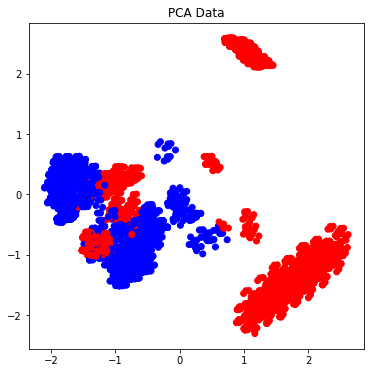

In [49]:
def PCA_2D(data):
    """
    This functions takes in a dataset and applies PCA
    on the dimensions to get the top 2 eigenvectors
    that captures the most variance in the data.
    
    The function returns the PCA model and the list of the
    projected positions of the input data on the prinipal 
    components.
    """
    pca_mod = PCA(n_components = 2)
    pca_mod.fit(data)
    pc1 = pca_mod.components_[0]
    pc2 = pca_mod.components_[1]
    pc_positions = np.zeros((len(data),2))
    for i, sample in enumerate(train_data):
        pc_positions[i,0] = np.dot(sample,pc1)
        pc_positions[i,1] = np.dot(sample,pc2) 
    return pca_mod, pc_positions

def P2():
    ## get the projected position and the PCA model
    pca, pc_pos = PCA_2D(train_data)
    print("Number of principal components:", len(pca.components_))
    
    ## Plot the data projected on the 2 prinicipal components
    ## red represents the poisonous mushrooms 
    ## blue represents the normal mushrooms
    plt.figure(figsize=(6, 6))
    cm_bright = ListedColormap(["#0000FF","#FF0000"])
    plt.scatter(pc_pos[:, 0], pc_pos[:, 1], 
          c=[i for i in train_labels], cmap=cm_bright)
    plt.title("PCA Data")

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

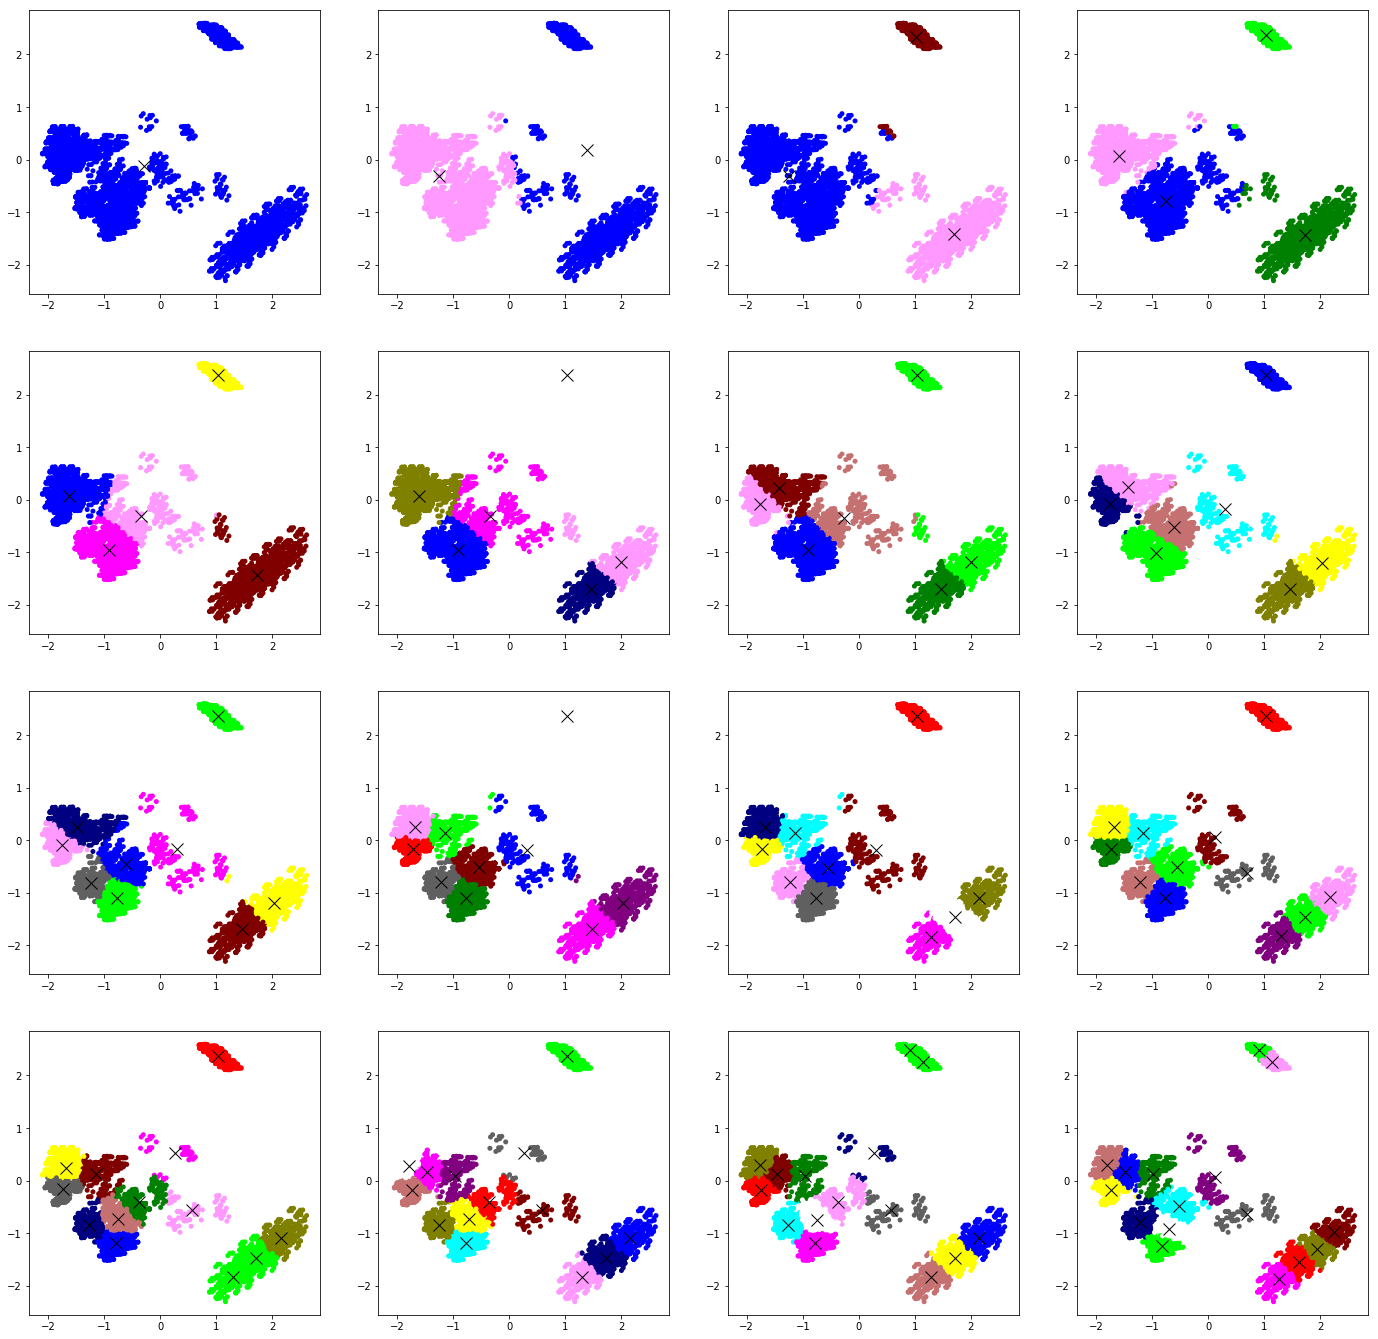

In [89]:
def P3():
    pca, pc_pos = PCA_2D(train_data)
    plt.figure(figsize=(24, 24))
    cm_bright = ListedColormap(["#0000FF","#FF0000","#00FF00","#FFFFFF",
                                "#FFFF00","#008000","#000080","#800080",
                                "#800000","#808000","#00FF00","#00FFFF",
                                "#FF00FF","#C67171","#606060","#FF99FF"])
    for k in range(16):
        km = KMeans(n_clusters=k+1, init="k-means++")
        km.fit(pc_pos)
        clusters = km.predict(pc_pos)
        p = plt.subplot(4, 4, k+1)
        #p.plot(pc_pos[:, 0], pc_pos[:, 1], ".",
        #       c=cm_bright[km.predict(pc_pos)], markersize=2)
        #c=cm_bright[clusters]
        p.scatter(pc_pos[:, 0], pc_pos[:, 1],
                  c=km.predict(pc_pos), cmap=cm_bright,
                  linewidths=2.0, marker=".")
        
        p.plot(km.cluster_centers_[:,0],km.cluster_centers_[:,1],
               "kx",markersize=12)
    
    #plt.scatter(pc_pos[:, 0], pc_pos[:, 1], 
    #      c=[i for i in train_labels], cmap=cm_bright)
    #plt.title("PCA Data")
        
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

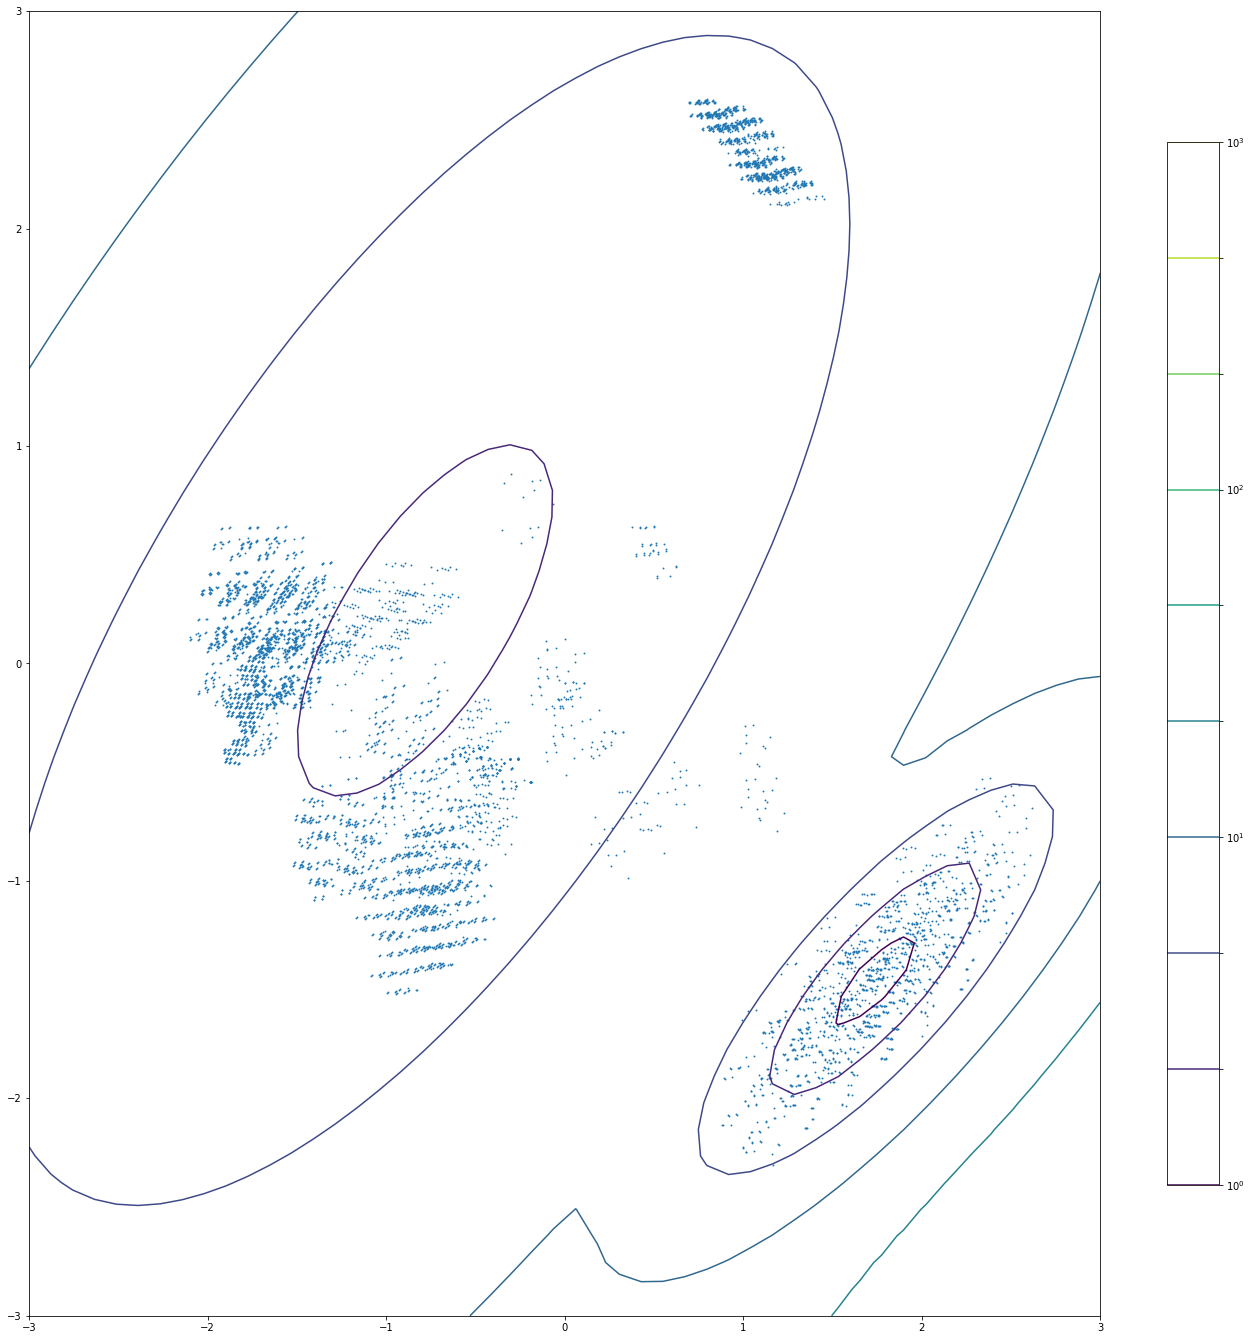

In [94]:
def P4():
    pca, pc_pos = PCA_2D(train_data)
    clf = GMM(n_components = 2)
    clf.fit(pc_pos)
    
    # display predicted scores by the model as a contour plot
    plt.figure(figsize=(24, 24))
    x = np.linspace(-3., 3.)
    y = np.linspace(-3., 3.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(pc_pos[:, 0], pc_pos[:, 1], .8)


    plt.axis('tight')
    plt.show()

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [93]:
def P5():
    clf = GMM(n_components=2)


P5()

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [6]:
def P6():


P6()